<a href="https://colab.research.google.com/github/iamviji/project/blob/master/EncoderOutputExperiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!rm -rf project
!git clone https://github.com/iamviji/project.git
!ls
!ls project
!pip install pyldpc
!pip install scikit-commpy



Cloning into 'project'...
remote: Enumerating objects: 175, done.
remote: Counting objects: 100% (175/175), done.
remote: Compressing objects: 100% (169/169), done.
remote: Total 175 (delta 72), reused 18 (delta 3), pack-reused 0
Receiving objects: 100% (175/175), 13.05 MiB | 10.70 MiB/s, done.
Resolving deltas: 100% (72/72), done.
project  sample_data
End2End8PSK.ipynb	    MainModelModCoding.ipynb
End2EndOneHotQPSK.ipynb     MainModelOneHotMethod.ipynb
End2EndQPSK.ipynb	    MainModelOneHotMethodSoftMax.ipynb
MainModel.ipynb		    MainModelWithSingleBERTraining.ipynb
MainModelKeras.ipynb	    README.md
MainModelKerasOneHot.ipynb  util.py
     |████████████████████████████████| 1.1MB 2.7MB/s 
  Created wheel for pyldpc: filename=pyldpc-0.7.9-cp36-none-any.whl size=14306 sha256=d705af6b58246504708d6e97c4528adeec9d605584fd33536ed1ed347deb03c1
  Stored in directory: /root/.cache/pip/wheels/47/7a/10/e94058ba8b0b6d98bf2719226d18d3dd6056525ad7b984c068
Successfully built pyldpc
     |███████████

In [2]:
import pyldpc
import commpy
import numpy 
import time
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior ()

Instructions for updating:
non-resource variables are not supported in the long term


In [3]:
SNR_BEGIN = 0
SNR_END = 10
SNR_STEP_SIZE = 0.5
CHANEL_SIZE = 18
NUM_OF_INPUT_MESSAGE = 1000
LDPC_MAX_ITER = 100
num_parity_check = 3
num_bits_in_parity_check = 6 
input_message_length =  0 # Caculated by channel encoder and initialized later

In [4]:
def timer_update(i,current,time_tot,tic_incr=500):
    last = current
    current = time.time()
    t_diff = current-last
    print('SNR: {:04.3f} - Iter: {} - Last {} iterations took {:03.2f}s'.format(snr,i+1,tic_incr,t_diff))
    return time_tot + t_diff

def Snr2Sigma(snr):
  sigma = 10 ** (- snr / 20)
  return sigma

def pyldpc_encode (CodingMatrix, message):
  rng = pyldpc.utils.check_random_state(seed=None)
  d = pyldpc.utils.binaryproduct(CodingMatrix, message)
  encoded_message = (-1) ** d
  return encoded_message

def pyldpc_decode (ParityCheckMatrix, CodingMatrix, message, snr, maxiter):
  decoded_msg = pyldpc.decode(ParityCheckMatrix, message, snr, maxiter)
  out_message = pyldpc.get_message(CodingMatrix, decoded_msg)
  return out_message

awgn_channel_input = tf.compat.v1.placeholder(tf.float64, [CHANEL_SIZE])
awgn_noise_std_dev = tf.placeholder(tf.float64)
awgn_noise = tf.random.normal(tf.shape(awgn_channel_input), stddev=awgn_noise_std_dev, dtype=tf.dtypes.float64)
awgn_channel_output = tf.add(awgn_channel_input, awgn_noise)

init = tf.global_variables_initializer ()
sess = tf.Session ()
sess.run(init)

def AWGNChannelOutput (xx, snr , s):
  sigma = Snr2Sigma (snr)
  awgn_channel_output_message = s.run ([awgn_channel_output], feed_dict={noise_std_dev:sigma, channel_input:xx})
  return awgn_channel_output_message

In [5]:

ParityCheckMatrix, CodingMatrix = pyldpc.make_ldpc(CHANEL_SIZE, num_parity_check, num_bits_in_parity_check, systematic=True, sparse=True)
input_message_length = CodingMatrix.shape[1]
print ("input_message_size=", input_message_length, "channel_size=",CHANEL_SIZE)
print ("input_message_size=", CodingMatrix.shape[1], "channel_size=",CodingMatrix.shape[0])
input_message = numpy.random.randint(2, size=(NUM_OF_INPUT_MESSAGE,input_message_length))
print (input_message)

input_message_size= 11 channel_size= 18
input_message_size= 11 channel_size= 18
[[0 1 0 ... 1 1 1]
 [1 1 1 ... 0 0 0]
 [0 1 0 ... 1 1 1]
 ...
 [1 0 0 ... 1 0 0]
 [1 1 1 ... 1 0 1]
 [0 0 1 ... 0 0 0]]


This section tries to compare BER and Time performance of PYLDPC in following 3 cases
1. SNR Noise function provided in encoder function of pyldpc library (pyldpc.encode)
2. SNR Noise function provided by commpy library (commpy.channels.awgn) 
3. SNR Noise function implemented using tensorflow 

In [6]:
# Here I am using tensor flow based AWGN, to make sure that effect of it is same as AWGN
output_display_counter = NUM_OF_INPUT_MESSAGE/4
ber_per_iter_tensor  = numpy.array(())
times_per_iter_tensor = numpy.array(())
for snr in numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE):
  total_bit_error = 0
  total_msg_error = 0
  total_time = 0
  current_time = time.time()
  for i in range (NUM_OF_INPUT_MESSAGE):
    encoded_message = pyldpc_encode (CodingMatrix, input_message[i])
    sigma = Snr2Sigma (snr)
    awgn_channel_output_message = sess.run ([awgn_channel_output], feed_dict={awgn_noise_std_dev:sigma, awgn_channel_input:encoded_message})[0]
    decoded_message = pyldpc_decode(ParityCheckMatrix, CodingMatrix, awgn_channel_output_message, snr, LDPC_MAX_ITER)
    if abs(decoded_message-input_message[i]).sum() != 0 :
      #print ("count=",abs(decoded_message-input_message[i]).sum())
      total_msg_error = total_msg_error + 1
    if (i+1) % output_display_counter == 0:
      total_time = timer_update(i, current_time,total_time, output_display_counter)
  ber = float(total_msg_error)/NUM_OF_INPUT_MESSAGE
  print('SNR: {:04.3f}:\n -> BER: {:03.2f}\n -> Total Time: {:03.2f}s'.format(snr,ber,total_time))
  ber_per_iter_tensor=numpy.append(ber_per_iter_tensor ,ber)
  times_per_iter_tensor=numpy.append(times_per_iter_tensor, total_time)

/usr/local/lib/python3.6/dist-packages/pyldpc/decoder.py:63: UserWarning: Decoding stopped before convergence. You may want
                       to increase maxiter
  to increase maxiter""")


SNR: 0.000 - Iter: 250 - Last 250.0 iterations took 1.87s
SNR: 0.000 - Iter: 500 - Last 250.0 iterations took 3.46s
SNR: 0.000 - Iter: 750 - Last 250.0 iterations took 4.97s
SNR: 0.000 - Iter: 1000 - Last 250.0 iterations took 6.61s
SNR: 0.000:
 -> BER: 0.62
 -> Total Time: 16.91s
SNR: 0.500 - Iter: 250 - Last 250.0 iterations took 1.32s
SNR: 0.500 - Iter: 500 - Last 250.0 iterations took 2.77s
SNR: 0.500 - Iter: 750 - Last 250.0 iterations took 4.20s
SNR: 0.500 - Iter: 1000 - Last 250.0 iterations took 5.49s
SNR: 0.500:
 -> BER: 0.53
 -> Total Time: 13.78s
SNR: 1.000 - Iter: 250 - Last 250.0 iterations took 0.95s
SNR: 1.000 - Iter: 500 - Last 250.0 iterations took 2.12s
SNR: 1.000 - Iter: 750 - Last 250.0 iterations took 3.29s
SNR: 1.000 - Iter: 1000 - Last 250.0 iterations took 4.33s
SNR: 1.000:
 -> BER: 0.42
 -> Total Time: 10.69s
SNR: 1.500 - Iter: 250 - Last 250.0 iterations took 0.88s
SNR: 1.500 - Iter: 500 - Last 250.0 iterations took 1.74s
SNR: 1.500 - Iter: 750 - Last 250.0 it

In [7]:
# Here I am using commpy based AWGN 
output_display_counter = NUM_OF_INPUT_MESSAGE/4
ber_per_iter_awgn  = numpy.array(())
times_per_iter_awgn = numpy.array(())
for snr in numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE):
  total_bit_error = 0
  total_msg_error = 0
  total_time = 0
  current_time = time.time()
  for i in range (NUM_OF_INPUT_MESSAGE):
    encoded_message = pyldpc_encode (CodingMatrix, input_message[i])
    awgn_channel_output_message = commpy.channels.awgn(encoded_message, snr)
    decoded_message = pyldpc_decode(ParityCheckMatrix, CodingMatrix, awgn_channel_output_message, snr, LDPC_MAX_ITER)
    if abs(decoded_message-input_message[i]).sum() != 0 :
      total_msg_error = total_msg_error + 1
    if (i+1) % output_display_counter == 0:
      total_time = timer_update(i, current_time,total_time, output_display_counter)
  ber = float(total_msg_error)/NUM_OF_INPUT_MESSAGE
  print('SNR: {:04.3f}:\n -> BER: {:03.2f}\n -> Total Time: {:03.2f}s'.format(snr,ber,total_time))
  ber_per_iter_awgn=numpy.append(ber_per_iter_awgn ,ber)
  times_per_iter_awgn=numpy.append(times_per_iter_awgn, total_time)

/usr/local/lib/python3.6/dist-packages/pyldpc/decoder.py:63: UserWarning: Decoding stopped before convergence. You may want
                       to increase maxiter
  to increase maxiter""")


SNR: 0.000 - Iter: 250 - Last 250.0 iterations took 1.53s
SNR: 0.000 - Iter: 500 - Last 250.0 iterations took 3.04s
SNR: 0.000 - Iter: 750 - Last 250.0 iterations took 4.56s
SNR: 0.000 - Iter: 1000 - Last 250.0 iterations took 5.98s
SNR: 0.000:
 -> BER: 0.59
 -> Total Time: 15.11s
SNR: 0.500 - Iter: 250 - Last 250.0 iterations took 1.17s
SNR: 0.500 - Iter: 500 - Last 250.0 iterations took 2.56s
SNR: 0.500 - Iter: 750 - Last 250.0 iterations took 3.80s
SNR: 0.500 - Iter: 1000 - Last 250.0 iterations took 5.02s
SNR: 0.500:
 -> BER: 0.53
 -> Total Time: 12.55s
SNR: 1.000 - Iter: 250 - Last 250.0 iterations took 0.99s
SNR: 1.000 - Iter: 500 - Last 250.0 iterations took 2.20s
SNR: 1.000 - Iter: 750 - Last 250.0 iterations took 3.19s
SNR: 1.000 - Iter: 1000 - Last 250.0 iterations took 4.20s
SNR: 1.000:
 -> BER: 0.46
 -> Total Time: 10.57s
SNR: 1.500 - Iter: 250 - Last 250.0 iterations took 0.80s
SNR: 1.500 - Iter: 500 - Last 250.0 iterations took 1.54s
SNR: 1.500 - Iter: 750 - Last 250.0 it

In [8]:
# Here I am using tensor flow based AWGN, to make sure that effect of it is same as AWGN
output_display_counter = NUM_OF_INPUT_MESSAGE/4
ber_per_iter_pyldpc  = numpy.array(())
times_per_iter_pyldpc = numpy.array(())
for snr in numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE):
  total_bit_error = 0
  total_msg_error = 0
  total_time = 0
  current_time = time.time()
  for i in range (NUM_OF_INPUT_MESSAGE):
    encoded_message = pyldpc.encode (CodingMatrix, input_message[i], snr)
    awgn_channel_output_message = encoded_message
    decoded_message = pyldpc_decode(ParityCheckMatrix, CodingMatrix, awgn_channel_output_message, snr, LDPC_MAX_ITER)
    if abs(decoded_message-input_message[i]).sum() != 0 :
      total_msg_error = total_msg_error + 1
    if (i+1) % output_display_counter == 0:
      total_time = timer_update(i, current_time,total_time, output_display_counter)
  ber = float(total_msg_error)/NUM_OF_INPUT_MESSAGE
  print('SNR: {:04.3f}:\n -> BER: {:03.2f}\n -> Total Time: {:03.2f}s'.format(snr,ber,total_time))
  ber_per_iter_pyldpc=numpy.append(ber_per_iter_pyldpc ,ber)
  times_per_iter_pyldpc=numpy.append(times_per_iter_pyldpc, total_time)

/usr/local/lib/python3.6/dist-packages/pyldpc/decoder.py:63: UserWarning: Decoding stopped before convergence. You may want
                       to increase maxiter
  to increase maxiter""")


SNR: 0.000 - Iter: 250 - Last 250.0 iterations took 1.54s
SNR: 0.000 - Iter: 500 - Last 250.0 iterations took 3.16s
SNR: 0.000 - Iter: 750 - Last 250.0 iterations took 4.62s
SNR: 0.000 - Iter: 1000 - Last 250.0 iterations took 6.25s
SNR: 0.000:
 -> BER: 0.62
 -> Total Time: 15.56s
SNR: 0.500 - Iter: 250 - Last 250.0 iterations took 1.20s
SNR: 0.500 - Iter: 500 - Last 250.0 iterations took 2.43s
SNR: 0.500 - Iter: 750 - Last 250.0 iterations took 3.68s
SNR: 0.500 - Iter: 1000 - Last 250.0 iterations took 4.90s
SNR: 0.500:
 -> BER: 0.52
 -> Total Time: 12.21s
SNR: 1.000 - Iter: 250 - Last 250.0 iterations took 1.05s
SNR: 1.000 - Iter: 500 - Last 250.0 iterations took 2.01s
SNR: 1.000 - Iter: 750 - Last 250.0 iterations took 3.11s
SNR: 1.000 - Iter: 1000 - Last 250.0 iterations took 4.13s
SNR: 1.000:
 -> BER: 0.45
 -> Total Time: 10.30s
SNR: 1.500 - Iter: 250 - Last 250.0 iterations took 0.78s
SNR: 1.500 - Iter: 500 - Last 250.0 iterations took 1.70s
SNR: 1.500 - Iter: 750 - Last 250.0 it

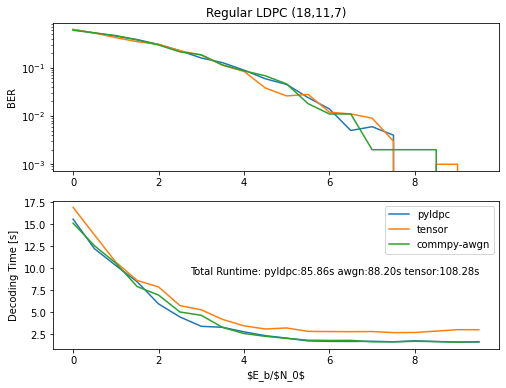

In [9]:
# Compare 3 AWGN(Tensorflow, CommPy, PYLDPC) Simulation on LDPC
import matplotlib.pyplot as plt
%matplotlib inline
snrs = numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE)
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(8,6))
ax1.semilogy(snrs,ber_per_iter_pyldpc,'', label="pyldpc") # plot BER vs SNR
ax1.semilogy(snrs,ber_per_iter_tensor,'', label="tensor") # plot BER vs SNR
ax1.semilogy(snrs,ber_per_iter_awgn,'', label="commpy-awgn") # plot BER vs SNR

ax1.set_ylabel('BER')
ax1.set_title('Regular LDPC ({},{},{})'.format(CHANEL_SIZE,input_message_length,CHANEL_SIZE-input_message_length))
ax2.plot(snrs,times_per_iter_pyldpc,'', label="pyldpc") # plot decode timing for different SNRs
ax2.plot(snrs,times_per_iter_tensor,'', label="tensor") # plot decode timing for different SNRs
ax2.plot(snrs,times_per_iter_awgn,'', label="commpy-awgn") # plot decode timing for different SNRs
ax2.set_xlabel('$E_b/$N_0$')
ax2.set_ylabel('Decoding Time [s]')
ax2.annotate('Total Runtime: pyldpc:{:03.2f}s awgn:{:03.2f}s tensor:{:03.2f}s'.format(numpy.sum(times_per_iter_pyldpc), 
            numpy.sum(times_per_iter_awgn), numpy.sum(times_per_iter_tensor)),
            xy=(1, 0.35), xycoords='axes fraction',
            xytext=(-20, 20), textcoords='offset pixels',
            horizontalalignment='right',
            verticalalignment='bottom')
plt.savefig('ldpc_ber_{}_{}.png'.format(CHANEL_SIZE,input_message_length))
plt.legend ()
plt.show()

<B>Conclussion:</B>
      It proved that tensorflow behaves similar to AWGN noise channel provided by pyldpc, commpy. But tensor flow based one takes adds little more time delay. This need to be offseted if we are comparing performance. 

In [10]:
def bits2int(a, axis=-1):
    return numpy.right_shift(numpy.packbits(a, axis=axis), 8 - a.shape[axis]).squeeze()


def row_bits2int(arr):
    n = arr.shape[1]  # number of columns
    # shift the bits of the first column to the left by n - 1
    a = arr[:, 0] << n - 1  

    for j in range(1, n):
        # "overlay" with the shifted bits of the next column
        a |= arr[:, j] << n - 1 - j  
    return a

In [322]:
# Define Model 

# input_message_length is initialized by ldpc encoder
num_hidden_1 = CHANEL_SIZE
print ("input_message_length=", input_message_length)

input_message_x = tf.placeholder("float32", [None, input_message_length], name="input_message_x")
awgn_noise_std_dev_x = tf.placeholder("float32", name ="awgn_noise_std_dev")
input_channel_x = tf.placeholder("float32", [None, CHANEL_SIZE], name="input_channel_x")
input_channel_out_ex = tf.placeholder("float32", [None, CHANEL_SIZE], name="input_channel_out_ex")
weights = {
  "encoder_l1" : tf.Variable (tf.random_uniform([input_message_length, num_hidden_1], -1, 1), name="encoder_l1_weights"),
  "decoder_l1" : tf.Variable (tf.random_uniform([num_hidden_1, input_message_length], -1, 1), name="decoder_l1_weights"),
  "decoder_l2" : tf.Variable (tf.random_uniform([input_message_length, input_message_length], -1, 1), name="decoder_l2_weights"),
}

biases = {
  "encoder_l1" : tf.Variable (tf.random_uniform([num_hidden_1], -1,1), name="encoder_l1_bias"),
  "decoder_l1" : tf.Variable (tf.random_uniform([input_message_length], -1,1), name="decoder_l1_bias"),
  "decoder_l2" : tf.Variable (tf.random_uniform([input_message_length], -1,1), name="decoder_l2_bias"),
}

def dl_encoder (x):
  layer_1 = tf.nn.tanh (tf.matmul(x, weights['encoder_l1']) + biases['encoder_l1'])
  #layer_2 = tf.round(layer_1)
  layer_2 =  layer_1 / tf.sqrt(tf.reduce_mean(tf.square(layer_1)))
  #layer_2 =  tf.nn.relu(layer_1)
  return layer_2

def dl_decoder (x):
  layer_1 = tf.nn.tanh (tf.matmul(x, weights['decoder_l1']) + biases['decoder_l1'])
  layer_2 = tf.nn.sigmoid (tf.matmul(layer_1, weights['decoder_l2']) + biases['decoder_l2'])
  return layer_2

def awgn_layer(x):
  awgn_noise = tf.random.normal(tf.shape(x), stddev=awgn_noise_std_dev_x,  name="awgn_noise")
  awgn_channel_output = tf.add(x, awgn_noise, name ="x_and_noise")
  return awgn_channel_output


dl_encoder_output = dl_encoder(input_message_x)
dl_decoder_input = awgn_layer(dl_encoder_output)
#awgn_noise = tf.random.normal(tf.shape(dl_encoder_output), stddev=awgn_noise_std_dev,  name="awgn_noise")
#dl_decoder_input = tf.add(dl_encoder_output, awgn_noise, name ="x_and_noise")
dl_decoder_output = dl_decoder (dl_decoder_input)
dl_decoder_only_output = dl_decoder(input_channel_x)
#print(numpy.mean(numpy.sqrt((numpy.square(regularizer_const*regularizer_const - encoded_message*encoded_message)))))
#print (numpy.mean(numpy.sqrt(numpy.square(numpy.multiply(regularizer_const-encoded_message, encoded_message)))))


#loss1 = tf.reduce_mean (-1 * (input_message_x*tf.log(dl_decoder_output) + (1 - input_message_x)*tf.log(1 - dl_decoder_output) )) + tf.reduce_max(tf.sqrt(tf.square(tf.math.multiply(input_channel_out_ex - dl_encoder_output, dl_encoder_output))))
loss1 = tf.reduce_mean (-1 * (input_message_x*tf.log(dl_decoder_output) + (1 - input_message_x)*tf.log(1 - dl_decoder_output) )) + tf.reduce_max((tf.square(input_channel_out_ex*input_channel_out_ex - dl_encoder_output*dl_encoder_output)))
lr = tf.placeholder(dtype=tf.float32,shape=[])
rms_optimizer = tf.train.AdamOptimizer(learning_rate=lr).minimize (loss1)
#rms_optimizer1 = tf.train.AdamOptimizer(learning_rate=lr).minimize (loss1)

input_message_length= 11


In [253]:
training_input_message = numpy.random.randint(2, size=(NUM_OF_INPUT_MESSAGE*10,input_message_length))
print (training_input_message)
print (len(training_input_message))

[[0 0 1 ... 1 0 1]
 [1 0 1 ... 0 1 0]
 [0 1 0 ... 0 0 1]
 ...
 [0 1 0 ... 0 0 1]
 [0 1 1 ... 0 1 1]
 [1 0 0 ... 0 0 0]]
10000


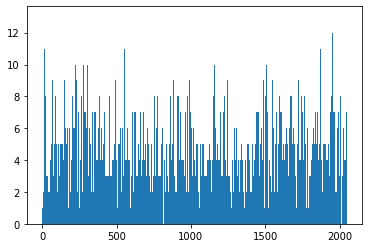

In [13]:
#input_message_length=8
#training_input_message = numpy.random.randint(2, size=(NUM_OF_INPUT_MESSAGE*10,input_message_length))
training_input_message_decimal = row_bits2int(training_input_message)
#uniqueValues, indicesList = numpy.unique(training_input_message_decimal, return_index=True)
x_axis = numpy.arange(0,2**input_message_length)
y_axis = row_bits2int(training_input_message)
#x=numpy.histogram(training_input_message_decimal,bins = x_axis) 
plt.hist(training_input_message_decimal, bins = x_axis) 
plt.show()

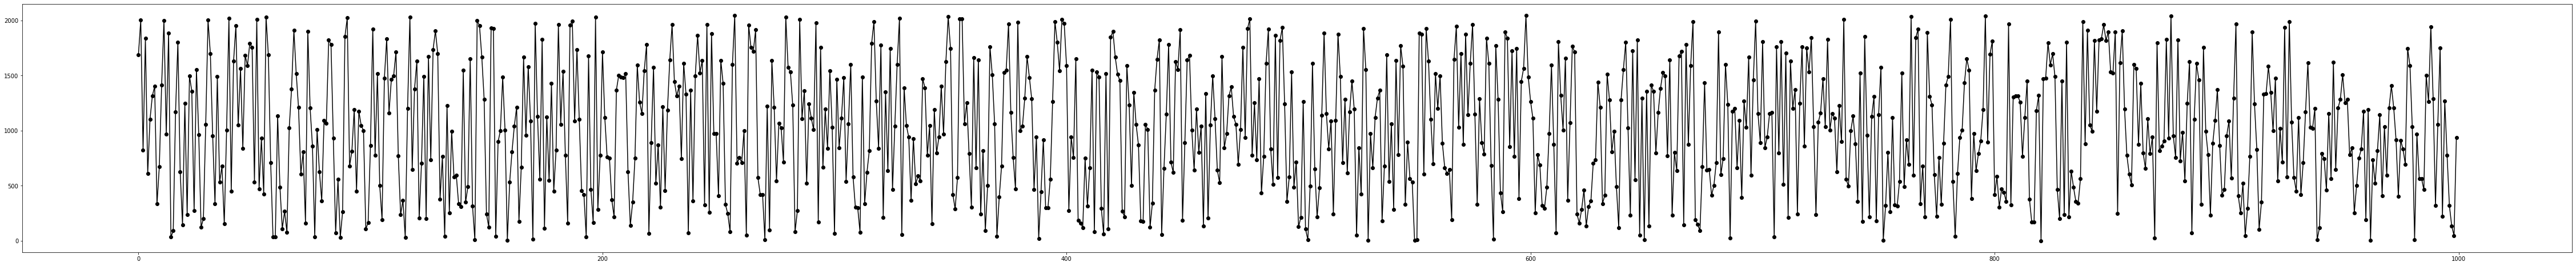

In [14]:
x_axis = numpy.arange(0,NUM_OF_INPUT_MESSAGE*10)
plt.figure(figsize=(80, 8))
plt.plot(x_axis[:NUM_OF_INPUT_MESSAGE],training_input_message_decimal[:NUM_OF_INPUT_MESSAGE], '-ok')

In [333]:
#learning : Suddenly drops after 8 SNR
batch_size = 300


# Training
train_init = tf.global_variables_initializer ()
train_sess = tf.Session ()

epochs = 40
outer_ephocs = 1
num_of_batches = len(training_input_message) / batch_size
display_step = 400
print ("batch_size:", batch_size, "num_of_batcches:", num_of_batches)
train_sess.run(train_init)
l = 0
lrate = .1
opt = rms_optimizer 
regularizer_const = numpy.ones((batch_size,CHANEL_SIZE), dtype=int)
#print (regularizer_const.shape)
#print (regularizer_const)
for oe in range(outer_ephocs):
  for snr in (numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE*2)):
    sigma = 1.0*Snr2Sigma (snr)
    if (snr>6): epochs = 200
    print ("Training for SNR=", snr, " sigma=", sigma) 
    for e in range(epochs):
      for j in range (int(num_of_batches)):
        k = e * epochs + j
        x_train_batch = training_input_message [j*batch_size:(j+1)*batch_size]
        x_train_batch_float = x_train_batch.astype("float32")
        _, l = train_sess.run ([opt, loss1], feed_dict={input_message_x:x_train_batch_float, awgn_noise_std_dev_x:sigma, lr:lrate, input_channel_out_ex:regularizer_const})
        encoded_message = train_sess.run ([dl_encoder_output], feed_dict={input_message_x:x_train_batch_float})
        encoded_message = numpy.asarray(encoded_message[0])
        #print (encoded_message)
        #print ("loss:", l)
        #print (numpy.multiply(regularizer_const-encoded_message, encoded_message))
        #print (numpy.mean(numpy.sqrt(numpy.square(numpy.multiply(regularizer_const-encoded_message, encoded_message)))))
        #print(numpy.mean(numpy.sqrt((numpy.square(regularizer_const*regularizer_const - encoded_message*encoded_message)))))
        
        if (l < 0.5): lrate = 0.001
        if (l < 0.25): lrate = 0.0005
        if (l < 0.1): lrate = 0.00002
        if k % display_step == 0:
          print('Step %i: Minibatch Loss: %f' % (i*display_step+j, l))

batch_size: 300 num_of_batcches: 33.333333333333336
Training for SNR= 0.0  sigma= 1.0
Step 399600: Minibatch Loss: 2.272009
Step 399600: Minibatch Loss: 1.401923
Step 399600: Minibatch Loss: 1.374091
Step 399600: Minibatch Loss: 1.386531
Training for SNR= 1.0  sigma= 0.8912509381337456
Step 399600: Minibatch Loss: 1.354350
Step 399600: Minibatch Loss: 1.356690
Step 399600: Minibatch Loss: 1.354888
Step 399600: Minibatch Loss: 1.382488
Training for SNR= 2.0  sigma= 0.7943282347242815
Step 399600: Minibatch Loss: 1.372653
Step 399600: Minibatch Loss: 0.434989
Step 399600: Minibatch Loss: 0.426137
Step 399600: Minibatch Loss: 0.418017
Training for SNR= 3.0  sigma= 0.7079457843841379
Step 399600: Minibatch Loss: 0.393611
Step 399600: Minibatch Loss: 0.371854
Step 399600: Minibatch Loss: 0.378549
Step 399600: Minibatch Loss: 0.341933
Training for SNR= 4.0  sigma= 0.6309573444801932
Step 399600: Minibatch Loss: 0.321273
Step 399600: Minibatch Loss: 0.316112
Step 399600: Minibatch Loss: 0.311

In [95]:
def bits2int(a, axis=-1):
    return numpy.right_shift(numpy.packbits(a, axis=axis), 8 - a.shape[axis]).squeeze()


def row_bits2int(arr):
    n = arr.shape[1]  # number of columns
    # shift the bits of the first column to the left by n - 1
    a = arr[:, 0] << n - 1  

    for j in range(1, n):
        # "overlay" with the shifted bits of the next column
        a |= arr[:, j] << n - 1 - j  
    return a

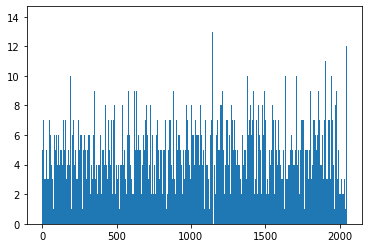

In [102]:
#input_message_length=8
#training_input_message = numpy.random.randint(2, size=(NUM_OF_INPUT_MESSAGE*10,input_message_length))
training_input_message_decimal = row_bits2int(training_input_message)
#uniqueValues, indicesList = numpy.unique(training_input_message_decimal, return_index=True)
x_axis = numpy.arange(0,2**input_message_length)
y_axis = row_bits2int(training_input_message)
#x=numpy.histogram(training_input_message_decimal,bins = x_axis) 
plt.hist(training_input_message_decimal, bins = x_axis) 
plt.show()

In [334]:
# Here I am using trained model
output_display_counter = NUM_OF_INPUT_MESSAGE/4
ber_per_iter_dl_tensor  = numpy.array(())
times_per_iter_dl_tensor = numpy.array(())

channel_in = []
channel_out = []
data_category = []

for snr in numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE):
  total_bit_error = 0
  total_msg_error = 0
  total_time = 0
  current_time = time.time()
  sigma = Snr2Sigma (snr)
  for i in range (NUM_OF_INPUT_MESSAGE):
    input_message_xx = training_input_message [i:i+1]
    data_category.append (training_input_message_decimal [i:i+1][0])
    input_message_xx_float = input_message_xx.astype("float32")
    encoded_message = train_sess.run ([dl_encoder_output], feed_dict={input_message_x:input_message_xx_float})
    channel_in.append(encoded_message[0][0]) 
    #print (encoded_message[0][0])
    awgn_channel_output_message = sess.run ([awgn_channel_output], feed_dict={awgn_noise_std_dev:sigma, awgn_channel_input:encoded_message[0][0]})
    channel_out.append(awgn_channel_output_message[0]) 
    #print (awgn_channel_output_message)
    decoded_message = train_sess.run ([dl_decoder_only_output], feed_dict={input_channel_x:awgn_channel_output_message})
    #print ("input", input_message[i])
    decoded_message = numpy.around(decoded_message[0][0]).astype(int)
    #print ("output", decoded_message)
    if abs(decoded_message-training_input_message[i]).sum() != 0 :
      total_msg_error = total_msg_error + 1
    if (i+1) % output_display_counter == 0:
      total_time = timer_update(i, current_time,total_time, output_display_counter)
  ber = float(total_msg_error)/NUM_OF_INPUT_MESSAGE
  print('SNR: {:04.3f}:\n -> BER: {:03.2f}\n -> Total Time: {:03.2f}s'.format(snr,ber,total_time))
  ber_per_iter_dl_tensor=numpy.append(ber_per_iter_dl_tensor ,ber)
  times_per_iter_dl_tensor=numpy.append(times_per_iter_dl_tensor, total_time)

SNR: 0.000 - Iter: 250 - Last 250.0 iterations took 1.02s
SNR: 0.000 - Iter: 500 - Last 250.0 iterations took 1.27s
SNR: 0.000 - Iter: 750 - Last 250.0 iterations took 1.53s
SNR: 0.000 - Iter: 1000 - Last 250.0 iterations took 1.79s
SNR: 0.000:
 -> BER: 0.94
 -> Total Time: 5.61s
SNR: 0.500 - Iter: 250 - Last 250.0 iterations took 0.26s
SNR: 0.500 - Iter: 500 - Last 250.0 iterations took 0.52s
SNR: 0.500 - Iter: 750 - Last 250.0 iterations took 0.78s
SNR: 0.500 - Iter: 1000 - Last 250.0 iterations took 1.05s
SNR: 0.500:
 -> BER: 0.93
 -> Total Time: 2.61s
SNR: 1.000 - Iter: 250 - Last 250.0 iterations took 0.27s
SNR: 1.000 - Iter: 500 - Last 250.0 iterations took 0.55s
SNR: 1.000 - Iter: 750 - Last 250.0 iterations took 0.82s
SNR: 1.000 - Iter: 1000 - Last 250.0 iterations took 1.07s
SNR: 1.000:
 -> BER: 0.94
 -> Total Time: 2.70s
SNR: 1.500 - Iter: 250 - Last 250.0 iterations took 0.28s
SNR: 1.500 - Iter: 500 - Last 250.0 iterations took 0.54s
SNR: 1.500 - Iter: 750 - Last 250.0 itera

In [337]:
channel_in.append (-1*numpy.ones((1,CHANEL_SIZE), dtype=int))
channel_in.append (numpy.ones((1,CHANEL_SIZE), dtype=int))

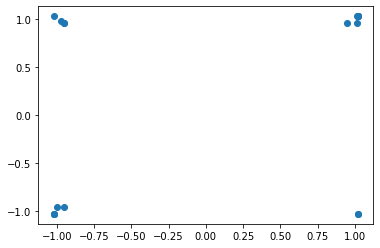

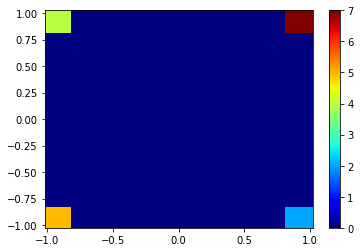

In [338]:
channel_in_array = numpy.transpose(channel_in)
import matplotlib.pyplot as plt
data_category.append(0)
data_category.append(0)
plt.scatter(channel_in_array[0], channel_in_array[1])

plt.show()
plt.hist2d(channel_in_array[0], channel_in_array[1], cmap=plt.cm.jet)
plt.colorbar()
plt.show()

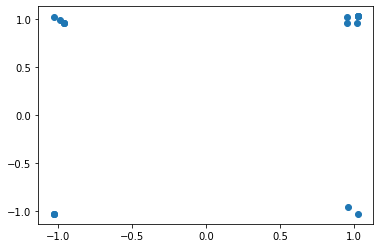

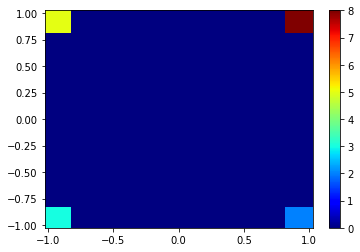

In [339]:
import matplotlib.pyplot as plt


plt.scatter(channel_in_array[4], channel_in_array[5])

plt.show()
plt.hist2d(channel_in_array[4], channel_in_array[5], cmap=plt.cm.jet)
plt.colorbar()
plt.show()

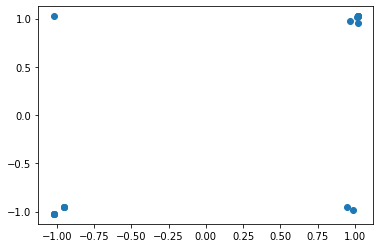

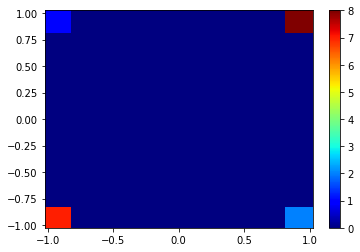

In [340]:
import matplotlib.pyplot as plt


plt.scatter(channel_in_array[6], channel_in_array[7])

plt.show()
plt.hist2d(channel_in_array[6], channel_in_array[7], cmap=plt.cm.jet)
plt.colorbar()
plt.show()


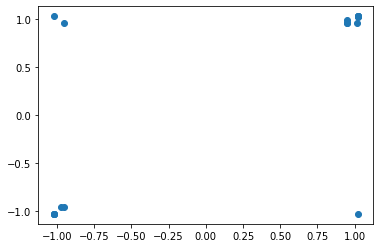

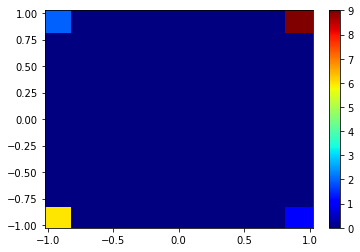

In [341]:
import matplotlib.pyplot as plt


plt.scatter(channel_in_array[8], channel_in_array[9])

plt.show()
plt.hist2d(channel_in_array[8], channel_in_array[9], cmap=plt.cm.jet)
plt.colorbar()
plt.show()


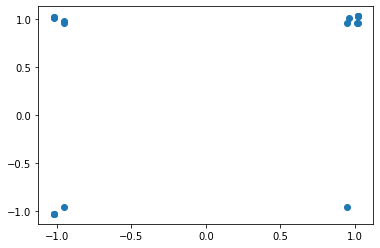

In [342]:
import matplotlib.pyplot as plt


plt.scatter(channel_in_array[10], channel_in_array[11])

plt.show()

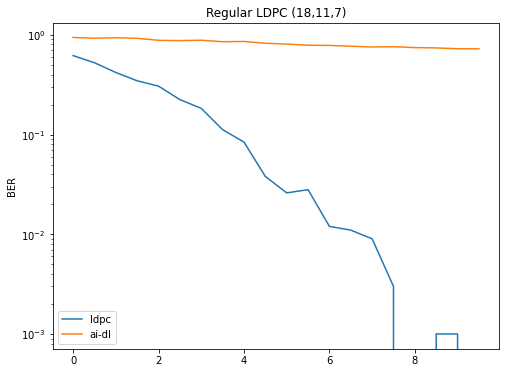

In [344]:
import matplotlib.pyplot as plt
%matplotlib inline
snrs = numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE)
fig, (ax1) = plt.subplots(1,1,figsize=(8,6))
ax1.semilogy(snrs,ber_per_iter_tensor,'', label="ldpc") # plot BER vs SNR
ax1.semilogy(snrs,ber_per_iter_dl_tensor,'', label="ai-dl") # plot BER vs SNR
ax1.set_ylabel('BER')
ax1.set_title('Regular LDPC ({},{},{})'.format(CHANEL_SIZE,input_message_length,CHANEL_SIZE-input_message_length))
#ax2.plot(snrs,times_per_iter_pyldpc,'', label="pyldpc") # plot decode timing for different SNRs
#ax2.plot(snrs,times_per_iter_tensor,'', label="tensor") # plot decode timing for different SNRs
#ax2.plot(snrs,times_per_iter_awgn,'', label="commpy-awgn") # plot decode timing for different SNRs
#ax2.set_xlabel('$E_b/$N_0$')
#ax2.set_ylabel('Decoding Time [s]')
#ax2.annotate('Total Runtime: pyldpc:{:03.2f}s awgn:{:03.2f}s tensor:{:03.2f}s'.format(numpy.sum(times_per_iter_pyldpc), 
#            numpy.sum(times_per_iter_awgn), numpy.sum(times_per_iter_tensor)),
#            xy=(1, 0.35), xycoords='axes fraction',
#            xytext=(-20, 20), textcoords='offset pixels',
#            horizontalalignment='right',
#            verticalalignment='bottom')
plt.savefig('ldpc_ber_{}_{}.png'.format(CHANEL_SIZE,input_message_length))
plt.legend ()
plt.show()

In [345]:
testing_input_message = numpy.random.randint(2, size=(NUM_OF_INPUT_MESSAGE,input_message_length))


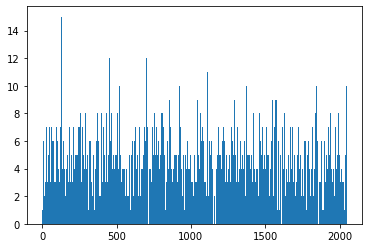

In [346]:
#input_message_length=8
#training_input_message = numpy.random.randint(2, size=(NUM_OF_INPUT_MESSAGE*10,input_message_length))
testing_input_message_decimal = row_bits2int(training_input_message)
#uniqueValues, indicesList = numpy.unique(training_input_message_decimal, return_index=True)
x_axis = numpy.arange(0,2**input_message_length)
y_axis = row_bits2int(testing_input_message)
#x=numpy.histogram(training_input_message_decimal,bins = x_axis) 
plt.hist(testing_input_message_decimal, bins = x_axis) 
plt.show()

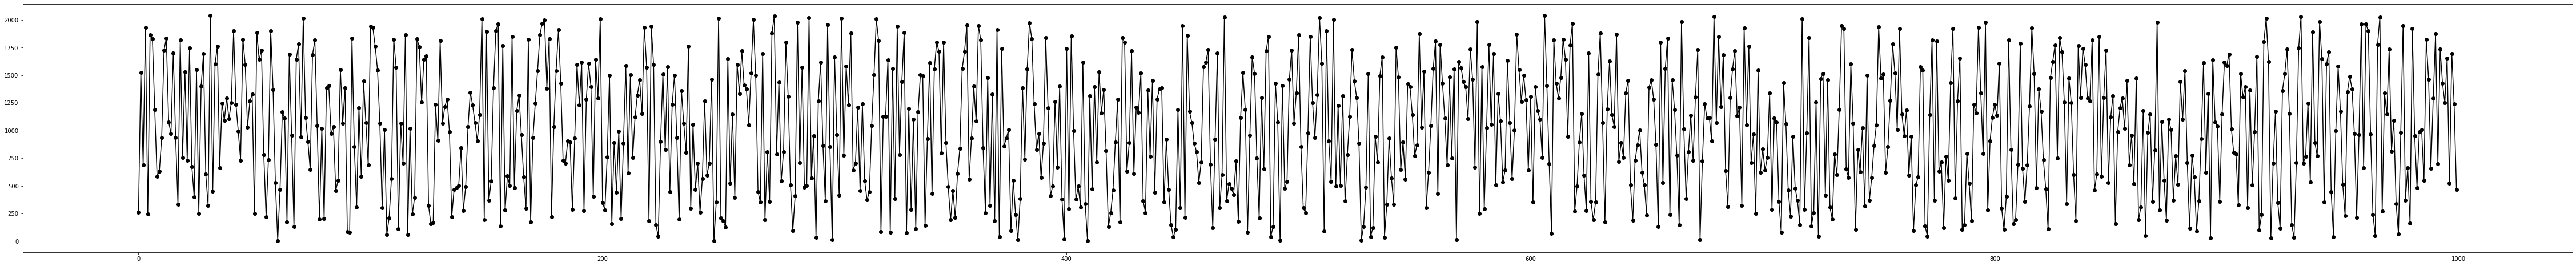

In [347]:
x_axis = numpy.arange(0,NUM_OF_INPUT_MESSAGE)
plt.figure(figsize=(80, 8))
plt.plot(x_axis[:NUM_OF_INPUT_MESSAGE],testing_input_message_decimal[:NUM_OF_INPUT_MESSAGE], '-ok')

In [348]:
# Here I am using trained model
output_display_counter = NUM_OF_INPUT_MESSAGE/4
ber_per_iter_dl_tensor  = numpy.array(())
times_per_iter_dl_tensor = numpy.array(())

for snr in numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE):
  total_bit_error = 0
  total_msg_error = 0
  total_time = 0
  current_time = time.time()
  sigma = Snr2Sigma (snr)
  for i in range (NUM_OF_INPUT_MESSAGE):
    input_message_xx = testing_input_message [i:i+1]
    input_message_xx_float = input_message_xx.astype("float32")
    encoded_message = train_sess.run ([dl_encoder_output], feed_dict={input_message_x:input_message_xx_float})
    #print (encoded_message[0][0])
    x = numpy.round(encoded_message[0][0])
    #print (x)
    #awgn_channel_output_message = sess.run ([awgn_channel_output], feed_dict={awgn_noise_std_dev:sigma, awgn_channel_input:encoded_message[0][0]})
    awgn_channel_output_message = sess.run ([awgn_channel_output], feed_dict={awgn_noise_std_dev:sigma, awgn_channel_input:x})
    #print (awgn_channel_output_message)
    decoded_message = train_sess.run ([dl_decoder_only_output], feed_dict={input_channel_x:awgn_channel_output_message})
    #print ("input", input_message[i])
    decoded_message = numpy.around(decoded_message[0][0]).astype(int)
    #print ("output", decoded_message)
    if abs(decoded_message-testing_input_message[i]).sum() != 0 :
      total_msg_error = total_msg_error + 1
    if (i+1) % output_display_counter == 0:
      total_time = timer_update(i, current_time,total_time, output_display_counter)
  ber = float(total_msg_error)/NUM_OF_INPUT_MESSAGE
  print('SNR: {:04.3f}:\n -> BER: {:03.2f}\n -> Total Time: {:03.2f}s'.format(snr,ber,total_time))
  ber_per_iter_dl_tensor=numpy.append(ber_per_iter_dl_tensor ,ber)
  times_per_iter_dl_tensor=numpy.append(times_per_iter_dl_tensor, total_time)

SNR: 0.000 - Iter: 250 - Last 250.0 iterations took 0.27s
SNR: 0.000 - Iter: 500 - Last 250.0 iterations took 0.55s
SNR: 0.000 - Iter: 750 - Last 250.0 iterations took 0.82s
SNR: 0.000 - Iter: 1000 - Last 250.0 iterations took 1.09s
SNR: 0.000:
 -> BER: 0.96
 -> Total Time: 2.73s
SNR: 0.500 - Iter: 250 - Last 250.0 iterations took 0.28s
SNR: 0.500 - Iter: 500 - Last 250.0 iterations took 0.54s
SNR: 0.500 - Iter: 750 - Last 250.0 iterations took 0.81s
SNR: 0.500 - Iter: 1000 - Last 250.0 iterations took 1.08s
SNR: 0.500:
 -> BER: 0.94
 -> Total Time: 2.70s
SNR: 1.000 - Iter: 250 - Last 250.0 iterations took 0.30s
SNR: 1.000 - Iter: 500 - Last 250.0 iterations took 0.56s
SNR: 1.000 - Iter: 750 - Last 250.0 iterations took 0.83s
SNR: 1.000 - Iter: 1000 - Last 250.0 iterations took 1.10s
SNR: 1.000:
 -> BER: 0.93
 -> Total Time: 2.78s
SNR: 1.500 - Iter: 250 - Last 250.0 iterations took 0.27s
SNR: 1.500 - Iter: 500 - Last 250.0 iterations took 0.53s
SNR: 1.500 - Iter: 750 - Last 250.0 itera

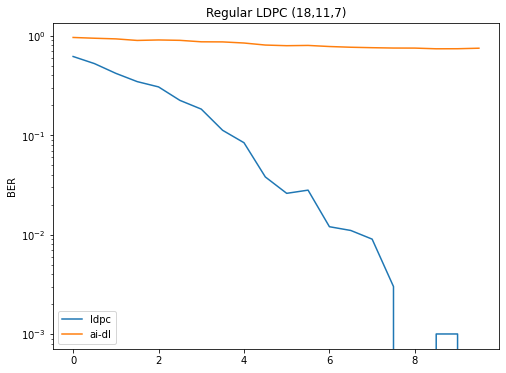

In [349]:
import matplotlib.pyplot as plt
%matplotlib inline
snrs = numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE)
fig, (ax1) = plt.subplots(1,1,figsize=(8,6))
ax1.semilogy(snrs,ber_per_iter_tensor,'', label="ldpc") # plot BER vs SNR
ax1.semilogy(snrs,ber_per_iter_dl_tensor,'', label="ai-dl") # plot BER vs SNR
ax1.set_ylabel('BER')
ax1.set_title('Regular LDPC ({},{},{})'.format(CHANEL_SIZE,input_message_length,CHANEL_SIZE-input_message_length))
#ax2.plot(snrs,times_per_iter_pyldpc,'', label="pyldpc") # plot decode timing for different SNRs
#ax2.plot(snrs,times_per_iter_tensor,'', label="tensor") # plot decode timing for different SNRs
#ax2.plot(snrs,times_per_iter_awgn,'', label="commpy-awgn") # plot decode timing for different SNRs
#ax2.set_xlabel('$E_b/$N_0$')
#ax2.set_ylabel('Decoding Time [s]')
#ax2.annotate('Total Runtime: pyldpc:{:03.2f}s awgn:{:03.2f}s tensor:{:03.2f}s'.format(numpy.sum(times_per_iter_pyldpc), 
#            numpy.sum(times_per_iter_awgn), numpy.sum(times_per_iter_tensor)),
#            xy=(1, 0.35), xycoords='axes fraction',
#            xytext=(-20, 20), textcoords='offset pixels',
#            horizontalalignment='right',
#            verticalalignment='bottom')
plt.savefig('ldpc_ber_{}_{}.png'.format(CHANEL_SIZE,input_message_length))
plt.legend ()
plt.show()